# PROJECT(P-150) RESUME CLASSIFICATION

### 1.BUISNESS OBJECTIVE:
   >>* The document classification system should significantly reduce the manual human effort in the HRM. It should achive a higher level of accuracy and automation with minimal human intrevention.
   

### 2.DATASET DETAILS:
   >>* We have dataset of resumes of people of different profile like Peoplesoft administration, SQL developer, React developer and workday developer.

## 3.IMPORTING NECESSARY LIBRARIES

In [1]:
!pip install python-docx
!pip install PyPDF2

In [2]:
import pandas as pd
import numpy as np
import os
import docx
import PyPDF2
import io

# MODELS

from sklearn.linear_model import LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# NLP [PRE-PROCESSING]

import nltk
import re
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\haari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 4. PRE-PROCESSING

In [3]:
# THIS FUNCTION WILL EXTRACT TEXT FROM RESUME
def getText(filename):
      
    fullText = ''
    if filename.endswith('.docx'):
        doc = docx.Document(filename)
        
        for para in doc.paragraphs:
            fullText = fullText + para.text
            
           
    elif filename.endswith('.pdf'):  
        with open(filename, "rb") as pdf_file:
            pdoc = PyPDF2.PdfFileReader(filename)
            number_of_pages = pdoc.getNumPages()
            page = pdoc.pages[0]
            page_content = page.extractText()
             
        for paragraph in page_content:
            fullText =  fullText + paragraph
            
    else:
        try:
            import aspose.words as aw
            output = aw.Document()
            output.remove_all_children()
            input = aw.Document(filename)
            output.append_document(input, aw.ImportFormatMode.KEEP_SOURCE_FORMATTING)
            output.save("Output.docx");
            doc = docx.Document('Output.docx')
        
            for para in doc.paragraphs:
                fullText = fullText + para.text
            fullText = fullText[79:]
        except:
            filename.endswith(".zip")
         
    return (fullText)

In [4]:
# THIS FUNCTION WILL TOKENIZE AND REMOVE PUNCTUATION.
def tokenText(extText):
   
    # Remove punctuation marks
    punc = '''!()-[]{};:'"\,.<>/?@#$%^&*_~'''
    puncText=" "
    for ele in extText:
        if ele in punc:
            puncText= extText.replace(ele, "")
    stop_words = set(stopwords.words('english'))
    puncText.split()
    word_tokens = word_tokenize(puncText)
    TokenizedText = [w for w in word_tokens if not w.lower() in stop_words]
    TokenizedText = []
  
    for w in word_tokens:
        if w not in stop_words:
            TokenizedText.append(w)
    return(TokenizedText)

In [5]:
# DEFINING KEY TERMS FOR ROLES APPLIED 
terms = {'WorkDay ERP':['workday', 'workday consultant', 'workday hcm', 'eib', 'picof', 
                        'workday studio','nnbound/outbound integrations'],
         'Peoplesoft':['peoplesoft', 'pia','ccb','birt','peci','ccw','pum','people tools',
                        'peoplesoft implementation','peoplesoft components',
                        'peoplesoft dba','peoplesoft admin','peoplesoft admin/dba','peopleSoft fscm', 
                        'peopletoolsupgrade','peopletools upgrade','process scheduler servers',
                        'peoplesoft hrms','peopleSoft consultant','peoplesoft cloud',
                        'PeopleSoft migrations','eoplesoft Testing Framework','pure internet architecture'],             
         'Database Developer':['sql','sql server', 'ms sql server','msbi', 'sql developer', 'ssis','ssrs',
                        'ssms','t-sql','tsql','Razorsql', 'razor sql','triggers','powerbi','power bi',
                        'oracle sql', 'pl/sql', 'pl\sql','oracle', 'oracle 11g','oledb','cte','ddl',
                        'dml','etl','mariadb','maria db'],
         'Java Developer':['reactjs', 'react js', 'react js developer', 'html', 'React JS'
                        'css3','xml','javascript','html5','boostrap','jquery', 'redux','php', 'node js',
                        'nodejs','apache','netbeans','nestjs','nest js','react developer','react hooks',
                        'jenkins']}

In [6]:
# LIST OF ALL KEY TERMS TO INDICATE SKILLSET
allTerms = ['workday', 'hcm', 'eib', 'picof','workday hcm',
                        'workday studio','nnbound/outbound integrations',
                        'peoplesoft', 'pia','ccb','birt','peci','ccw','pum','people tools',
                        'peoplesoft implementation','peoplesoft components',
                        'peoplesoft dba','peoplesoft admin','peoplesoft admin/dba','peopleSoft fscm', 
                        'peopletoolsupgrade','peopletools upgrade','process scheduler servers',
                        'peoplesoft hrms','peopleSoft consultant','peopledoft cloud',
                        'PeopleSoft migrations','eoplesoft Testing Framework','pure internet architecture',
                        'sql','sql server', 'ms sql server','msbi', 'sql developer', 'ssis','ssrs',
                        'ssms','t-sql','tsql','Razorsql', 'razor sql','triggers','powerbi','power bi',
                        'oracle sql', 'pl/sql', 'pl\sql','oracle', 'oracle 11g','oledb','cte','ddl',
                        'dml','etl','mariadb','maria db','reactjs', 'react js', 'react js developer', 'html', 
                        'css3','xml','javascript','html5','boostrap','jquery', 'redux','php', 'node js',
                        'nodejs','apache','netbeans','nestjs','nest js','react developer','react hooks',
                        'jenkins']

In [7]:
# THIS FUNCTION WILL READ TOKENIZD TEXT AND READ KEYWORDS FOR ROLE APPLIED
def roleApplied (Text):
    
    # CONVERT TEXT INTO LOWER CASE
    for i in range(len(Text)):
        Text[i] = Text[i].lower()
    
    for area in terms.keys():
        if area == 'WorkDay ERP':
            for word in terms[area]:
                if word in Text:
                    role = area
                    return (role)
                
        elif area == 'Peoplesoft':
            for word in terms[area]:
                if word in Text:
                    role = area
                    return(role)   
                
        elif area == 'Database Developer':
            for word in terms[area]:
                if word in Text:
                    role =  area
                    return(role)
            
        elif area == 'Java Developer':
             for word in terms[area]:
                if word in Text:
                    role = area
                    return(role)
        else:
            role = "Fresher"
            return(role)

In [8]:
# Function to extract Name and contact details
def contactDetails(Text):
    name = ''  
    for i in range(0,3):
        name = " ".join([name,Text[i]])
    return(name)

In [9]:
# EXPERIENCE DETAILS
def expDetails(Text):
    global sent
   
    Text = Text.split()
   
    for i in range(len(Text)-2):
        Text[i].lower()
        
        if Text[i] ==  'years':
            sent =  Text[i-2] + ' ' + Text[i-1] +' ' + Text[i] +' '+ Text[i+1] +' ' + Text[i+2]
            return (sent)

In [10]:
# SKILL SET
def skillSet(Text):
    t = []
    for i in range(len(Text)):
        if Text[i] in allTerms:
            if Text[i] in t:
                continue
            t.append(Text[i]) 
    return(t)

In [11]:
ResumeText = pd.DataFrame([], columns=['Name','RoleApplied', 'Experience', 'SkillSet','TextInfo'])

# PATH OF FOLDER WHERE RESUME ARE STORED
path = r"C:/Users/haari/OneDrive/Desktop/P150_Resume_Classification/Resumes"
text =[]

# Search the directory path and loop through the resume documents and callthe function getText
for filename in os.listdir(path):
    filename = os.path.join(path, filename)
    extText = getText(filename)
    #print(type(extText))
    tokText = tokenText(extText)
    #print(extText)
    role = roleApplied(tokText)
    Name = contactDetails(tokText)
    experience = expDetails(extText)
    skills = skillSet(tokText)
    NewRow = [Name,role,experience, skills,tokText]  
    ResumeText.loc[len(ResumeText)] = NewRow

In [12]:
ResumeText

,Name,RoleApplied,Experience,SkillSet,TextInfo
0,anil kumar maddukuri,Database Developer,Developer Summary2.4 years of experience,"[sql, msbi, ssms, ssis, ssrs, triggers, cte, etl]","[anil, kumar, maddukuri, sql, &, msbi, develop..."
1,aradhana tripathicurrent location,Database Developer,than 4 years of working,"[sql, mariadb, triggers, ddl, dml, t-sql, ssms]","[aradhana, tripathicurrent, location, :, gachi..."
2,buddha vamsi career,Database Developer,OBJECTIVE:Have 2.11 years of IT,"[sql, oracle, triggers, cte, etl]","[buddha, vamsi, career, objective, :, have, 21..."
3,chinna subbarayudu mdob,WorkDay ERP,around 5.1 years of IT,"[workday, hcm, etl, eib, xml, ccw, picof, peci...","[chinna, subbarayudu, mdob, 06th, march, 1994n..."
4,name : gopi,WorkDay ERP,with 3+ years as Workday,"[workday, hcm, eib, picof, xml, birt]","[name, :, gopi, krishna, reddy, professional, ..."
...,...,...,...,...,...
74,workday | hcm,WorkDay ERP,Summary:Having 6+ years of experience,"[workday, hcm, eib, xml, peci, peoplesoft]","[workday, |, hcm, |, fcmname, :, kumar, ssrole..."
75,career objective a,Database Developer,with 3.2 years of total,"[sql, cte, t-sql, triggers]","[career, objective, a, rewarding, opportunity,..."
76,venkateswarlu.b workday consultant,WorkDay ERP,Having 5.3 years of experience,"[workday, hcm, birt, eib, xml]","[venkateswarlu.b, workday, consultant, having,..."
77,vinay kumar v,WorkDay ERP,Having 4.2 years of Total,"[workday, hcm, eib, xml, peoplesoft]","[vinay, kumar, v, workday, functional, consult..."


In [13]:
df=ResumeText

## 5. EXPLORATORY DATA ANALYSIS [ EDA ]

In [14]:
# TELLS NUMBER OF ROWS AND COLUMN
df.shape

(79, 5)

In [15]:
ResumeText[ResumeText['RoleApplied'].isna()] #SHOWS NULL VALUE

,Name,RoleApplied,Experience,SkillSet,TextInfo
9,name ravali p,None,None,[],"[name, ravali, p, curriculum, vitae, specializ..."
59,curriculum vitaethis document,None,None,[],"[curriculum, vitaethis, document, truncated, c..."
61,venkatalakshmi pedireddysoftware developerexp...,None,None,[],"[venkatalakshmi, pedireddysoftware, developere..."


In [16]:
ResumeText[ResumeText['Name'].isna()]

,Name,RoleApplied,Experience,SkillSet,TextInfo


In [17]:
ResumeText[ResumeText['SkillSet'].isna()]

,Name,RoleApplied,Experience,SkillSet,TextInfo


In [18]:
ResumeText[ResumeText['TextInfo'].isna()]

,Name,RoleApplied,Experience,SkillSet,TextInfo


In [19]:
ResumeText['RoleApplied'].value_counts()

WorkDay ERP           21
Peoplesoft            20
Database Developer    18
Java Developer        17
Name: RoleApplied, dtype: int64

(array([1., 0., 1., 0., 0., 0., 0., 1., 0., 1.]),
 array([17. , 17.4, 17.8, 18.2, 18.6, 19. , 19.4, 19.8, 20.2, 20.6, 21. ]),
 <BarContainer object of 10 artists>)

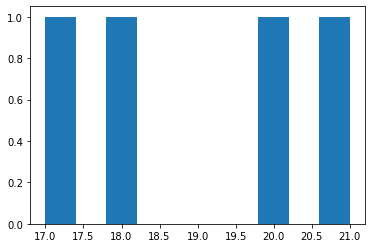

In [20]:
import matplotlib.pyplot as plt
plt.hist(ResumeText['RoleApplied'].value_counts())

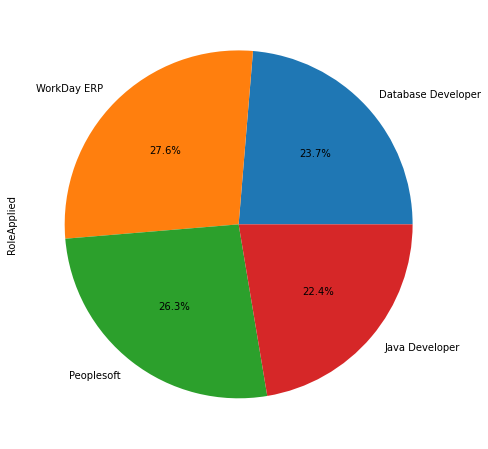

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
ResumeText['RoleApplied'].value_counts(sort=False).plot.pie(autopct='%1.1f%%')
plt.show()

In [22]:
stopwords=stopwords.words("english")

In [23]:
from nltk.stem.porter import PorterStemmer 
import re
ps=PorterStemmer()

In [24]:
def preprocess(x):
         x=re.sub('[^a-zA-Z ]', ' ', x)
         x=x.lower()
         x=x.split()  
         x=[word  for word in x if word not in set(stopwords.words('english'))]  
         x=[ps.stem(word) for word in x] 
         x=" ".join(x)
         return x

In [25]:
#tem.review=tem.review.apply(lambda x: [ps.stem(word) for word in x])
ResumeText.TextInfo=ResumeText.TextInfo.apply(lambda x: [ps.stem(word) for word in x])

In [26]:
ResumeText.head()

,Name,RoleApplied,Experience,SkillSet,TextInfo
0,anil kumar maddukuri,Database Developer,Developer Summary2.4 years of experience,"[sql, msbi, ssms, ssis, ssrs, triggers, cte, etl]","[anil, kumar, maddukuri, sql, &, msbi, develop..."
1,aradhana tripathicurrent location,Database Developer,than 4 years of working,"[sql, mariadb, triggers, ddl, dml, t-sql, ssms]","[aradhana, tripathicurr, locat, :, gachibowli,..."
2,buddha vamsi career,Database Developer,OBJECTIVE:Have 2.11 years of IT,"[sql, oracle, triggers, cte, etl]","[buddha, vamsi, career, object, :, have, 211, ..."
3,chinna subbarayudu mdob,WorkDay ERP,around 5.1 years of IT,"[workday, hcm, etl, eib, xml, ccw, picof, peci...","[chinna, subbarayudu, mdob, 06th, march, 1994n..."
4,name : gopi,WorkDay ERP,with 3+ years as Workday,"[workday, hcm, eib, picof, xml, birt]","[name, :, gopi, krishna, reddi, profession, su..."


In [27]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
lb=preprocessing.LabelEncoder()
ResumeText['role']= lb.fit_transform(ResumeText['RoleApplied'])

In [28]:
df=pd.DataFrame(ResumeText.drop(["Name"],axis=1))
df=df.drop(["RoleApplied"],axis=1)
df=df.drop(["Experience"],axis=1)
df=df.drop(["SkillSet"],axis=1)

In [29]:
df.head()

,TextInfo,role
0,"[anil, kumar, maddukuri, sql, &, msbi, develop...",0
1,"[aradhana, tripathicurr, locat, :, gachibowli,...",0
2,"[buddha, vamsi, career, object, :, have, 211, ...",0
3,"[chinna, subbarayudu, mdob, 06th, march, 1994n...",3
4,"[name, :, gopi, krishna, reddi, profession, su...",3


In [30]:
df.role

0     0
1     0
2     0
3     3
4     3
     ..
74    3
75    0
76    3
77    3
78    0
Name: role, Length: 79, dtype: int32

In [31]:
df.TextInfo=df.TextInfo.apply(lambda x: " ".join(x))

In [32]:
df.head()

,TextInfo,role
0,anil kumar maddukuri sql & msbi develop summar...,0
1,"aradhana tripathicurr locat : gachibowli , hyd...",0
2,buddha vamsi career object : have 211 year it ...,0
3,chinna subbarayudu mdob 06th march 1994nation ...,3
4,name : gopi krishna reddi profession summeri :...,3


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [34]:
vectorizer = TfidfVectorizer()

tfidf = vectorizer.fit_transform(df.TextInfo.values).toarray() 
final_df=pd.DataFrame(tfidf,columns=vectorizer.vocabulary_)
final_df

,anil,kumar,maddukuri,sql,msbi,develop,summary2,year,experi,ms,...,after,nsdcrole,tablesdevelop,functionsbi,tablesinvolv,datarespons,logicexperi,toolinvolv,emailerinvolv,bib
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.047206,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
final_df['Role']=df['role']
final_df

,anil,kumar,maddukuri,sql,msbi,develop,summary2,year,experi,ms,...,nsdcrole,tablesdevelop,functionsbi,tablesinvolv,datarespons,logicexperi,toolinvolv,emailerinvolv,bib,Role
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.047206,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
75,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
76,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
77,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## 6. MODEL BUILDING

In [36]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [37]:
X=final_df.drop('Role', axis=1)
Y=final_df.Role

In [38]:
# SPLITTING DATASET INTO TRAINING DATA AND TESTING DATA
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=78) 

In [39]:
X_train.shape,X_test.shape ,Y_train.shape ,Y_test.shape 

((63, 5109), (16, 5109), (63,), (16,))

### 1.  DECISION TREE CLASSIFIER

In [40]:
clf_dt=DecisionTreeClassifier() 
clf_dt.fit(X_train,Y_train) # Training Model
y_pred_train=clf_dt.predict(X_train)
y_pred_test=clf_dt.predict(X_test)# Testing Model
y_pred_train,y_pred_test

(array([1, 0, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 3, 0,
        3, 2, 2, 1, 3, 3, 2, 1, 0, 3, 1, 4, 0, 2, 1, 2, 2, 1, 4, 0, 2, 0,
        2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1]),
 array([3, 0, 1, 3, 1, 0, 0, 4, 0, 0, 3, 2, 0, 0, 2, 3]))

#### ACCURACY OF MODEL

In [42]:
acc_dt_train1=accuracy_score(Y_train,y_pred_train)
acc_dt_train1

1.0

In [43]:
acc_dt_test1=accuracy_score(Y_test,y_pred_test)
acc_dt_test1

0.9375

#### CLASSIFICATION REPORT

In [44]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1

    accuracy                           0.94        16
   macro avg       0.97      0.93      0.94        16
weighted avg       0.95      0.94      0.93        16



### 2. RANDOM FOREST CLASSIFIER


In [45]:
clf_rfc=RandomForestClassifier(n_estimators = 100) 
clf_rfc.fit(X_train,Y_train) # Training Model
y_pred_train=clf_rfc.predict(X_train)
y_pred_test=clf_rfc.predict(X_test)# Testing Model
y_pred_train,y_pred_test

(array([1, 0, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 3, 0,
        3, 2, 2, 1, 3, 3, 2, 1, 0, 3, 1, 4, 0, 2, 1, 2, 2, 1, 4, 0, 2, 0,
        2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1]),
 array([3, 1, 1, 3, 1, 0, 0, 1, 0, 0, 3, 2, 1, 1, 2, 3]))

#### ACCURACY  OF MODEL

In [46]:
acc_dt_train2=accuracy_score(Y_train,y_pred_train)
acc_dt_train2

1.0

In [47]:
acc_dt_test2=accuracy_score(Y_test,y_pred_test)
acc_dt_test2

0.8125

#### CLASSIFICATION REPORT

In [48]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.50      1.00      0.67         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         1

    accuracy                           0.81        16
   macro avg       0.70      0.73      0.69        16
weighted avg       0.84      0.81      0.80        16



C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3. ADA-BOOST CLASSIFIER

In [49]:
clf_abc=AdaBoostClassifier(n_estimators=10, random_state=7) 
clf_abc.fit(X_train,Y_train) # Training Model
y_pred_train=clf_abc.predict(X_train)
y_pred_test=clf_abc.predict(X_test)# Testing Model
y_pred_train,y_pred_test

(array([2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
        3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
        2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2]),
 array([3, 2, 2, 3, 2, 2, 2, 4, 2, 2, 3, 2, 2, 4, 2, 3]))

#### ACCURACY OF MODEL

In [50]:
acc_dt_train3=accuracy_score(Y_train,y_pred_train)
acc_dt_train3

0.5873015873015873

In [51]:
acc_dt_test3=accuracy_score(Y_test,y_pred_test)
acc_dt_test3

0.4375

#### CLASSIFICATION REPORT

In [53]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         2
           3       1.00      0.75      0.86         4
           4       0.33      1.00      0.50         1

    accuracy                           0.81        16
   macro avg       0.83      0.82      0.77        16
weighted avg       0.90      0.81      0.83        16



### 4. GRADIENT BOOSTING CLASSIFIER

In [52]:
clf_gb=GradientBoostingClassifier(learning_rate= 0.2, random_state= 7) 
clf_gb.fit(X_train,Y_train) # Training Model
y_pred_train=clf_gb.predict(X_train)
y_pred_test=clf_gb.predict(X_test)# Testing Model
y_pred_train,y_pred_test

(array([1, 0, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 3, 0,
        3, 2, 2, 1, 3, 3, 2, 1, 0, 3, 1, 4, 0, 2, 1, 2, 2, 1, 4, 0, 2, 0,
        2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1]),
 array([3, 0, 1, 3, 1, 0, 0, 4, 0, 0, 4, 2, 1, 4, 0, 3]))

#### ACCURACY OF MODEL

In [54]:
acc_dt_train4=accuracy_score(Y_train,y_pred_train)
acc_dt_train4

1.0

In [55]:
acc_dt_test4=accuracy_score(Y_test,y_pred_test)
acc_dt_test4

0.8125

#### CLASSIFICATION REPORT

In [56]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         2
           3       1.00      0.75      0.86         4
           4       0.33      1.00      0.50         1

    accuracy                           0.81        16
   macro avg       0.83      0.82      0.77        16
weighted avg       0.90      0.81      0.83        16



### 5. XGB CLASSIFIER

In [57]:
clf_xgb=XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimator=100, random_state=7)
clf_xgb.fit(X_train,Y_train) # Training Model
y_pred_train=clf_xgb.predict(X_train)
y_pred_test=clf_xgb.predict(X_test)# Testing Model
y_pred_train,y_pred_test

[18:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




(array([1, 0, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 3, 0,
        3, 2, 2, 1, 3, 3, 2, 1, 0, 3, 1, 4, 0, 2, 1, 2, 2, 1, 4, 0, 2, 0,
        2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1],
       dtype=int64),
 array([3, 0, 1, 3, 1, 0, 0, 4, 0, 0, 3, 2, 1, 4, 2, 3], dtype=int64))

#### ACCURACY OF MODEL

In [58]:
acc_dt_train5=accuracy_score(Y_train,y_pred_train)
acc_dt_train5

1.0

In [59]:
acc_dt_test5=accuracy_score(Y_test,y_pred_test)
acc_dt_test5

0.9375

#### CLASSIFICATION REPORT

In [60]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.50      1.00      0.67         1

    accuracy                           0.94        16
   macro avg       0.90      0.97      0.92        16
weighted avg       0.97      0.94      0.95        16



### 6. SUPPORT VECTOR MACHINE CLASSIFIER

In [61]:
# Finding Best parameter using GridSearch CV
param_grid = {'C': [ 10, 15, 20], 'gamma': [50,100],'kernel':['rbf','poly']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................C=10, gamma=50, kernel=rbf; total time=   0.0s
[CV] END .........................C=10, gamma=50, kernel=rbf; total time=   0.0s
[CV] END .........................C=10, gamma=50, kernel=rbf; total time=   0.0s


C:\Users\haari\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV] END .........................C=10, gamma=50, kernel=rbf; total time=   0.0s
[CV] END .........................C=10, gamma=50, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=50, kernel=poly; total time=   0.0s
[CV] END ........................C=10, gamma=50, kernel=poly; total time=   0.0s
[CV] END ........................C=10, gamma=50, kernel=poly; total time=   0.0s
[CV] END ........................C=10, gamma=50, kernel=poly; total time=   0.0s
[CV] END ........................C=10, gamma=50, kernel=poly; total time=   0.0s
[CV] END ........................C=10, gamma=100, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=100, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=100, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=100, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=100, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [10, 15, 20], 'gamma': [50, 100],
                         'kernel': ['rbf', 'poly']},
             verbose=2)

In [62]:
grid.best_params_

{'C': 10, 'gamma': 50, 'kernel': 'poly'}

In [63]:
clf_svc=OneVsRestClassifier(SVC(C= 10, gamma= 50, kernel= 'poly'))
clf_svc.fit(X_train,Y_train) # Training Model
y_pred_train=clf_svc.predict(X_train)
y_pred_test=clf_svc.predict(X_test)# Testing Model
y_pred_train,y_pred_test

(array([1, 0, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 3, 0,
        3, 2, 2, 1, 3, 3, 2, 1, 0, 3, 1, 4, 0, 2, 1, 2, 2, 1, 4, 0, 2, 0,
        2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1]),
 array([3, 1, 1, 3, 1, 0, 0, 2, 0, 0, 3, 2, 1, 1, 2, 3]))

#### ACCURACY OF MODEL

In [64]:
acc_dt_train6=accuracy_score(Y_train,y_pred_train)
acc_dt_train6

1.0

In [65]:
acc_dt_test6=accuracy_score(Y_test,y_pred_test)
acc_dt_test6

0.8125

#### CLASSIFICATION REPORT

In [66]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.60      1.00      0.75         3
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         1

    accuracy                           0.81        16
   macro avg       0.65      0.73      0.67        16
weighted avg       0.82      0.81      0.79        16



C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 7. KNN CLASSIFIER

In [67]:
# Finding Best parameter using GridSearch CV
param_grid = {'n_neighbors':[5,10,15,20]}
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s


C:\Users\haari\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15, 20]}, verbose=2)

In [68]:
grid.best_params_

{'n_neighbors': 5}

In [69]:
clf_knn=KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train,Y_train) # Training Model
y_pred_train=clf_knn.predict(X_train)
y_pred_test=clf_knn.predict(X_test)# Testing Model
y_pred_train,y_pred_test

(array([1, 1, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 3, 0,
        3, 2, 2, 1, 3, 3, 2, 1, 0, 3, 1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 0,
        2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1]),
 array([3, 1, 1, 3, 1, 0, 0, 3, 0, 0, 3, 2, 1, 1, 2, 3]))

#### ACCURACY OF MODEL

In [70]:
acc_dt_train7=accuracy_score(Y_train,y_pred_train)
acc_dt_train7

0.9523809523809523

In [72]:
acc_dt_test7=accuracy_score(Y_test,y_pred_test)
acc_dt_test7

0.8125

#### CLASSIFICATION REPORT

In [73]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.60      1.00      0.75         3
           2       1.00      1.00      1.00         2
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         1

    accuracy                           0.81        16
   macro avg       0.68      0.73      0.69        16
weighted avg       0.81      0.81      0.79        16



C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 8. MNB CLASSIFIER

In [74]:
# Finding Best parameter using GridSearch CV
param_grid = {'alpha':[0.5,1.0],'fit_prior':['True','False']}
grid = GridSearchCV(MultinomialNB(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s


C:\Users\haari\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=1.0, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=1.0, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=1.0, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=1.0, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=1.0, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=1.0, fit_prior=False; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0], 'fit_prior': ['True', 'False']},
             verbose=2)

In [75]:
grid.best_params_

{'alpha': 1.0, 'fit_prior': 'True'}

In [76]:
clf_mnb=MultinomialNB(alpha=1.0, fit_prior=True)
clf_mnb.fit(X_train,Y_train) # Training Model
y_pred_train=clf_mnb.predict(X_train)
y_pred_test=clf_mnb.predict(X_test)# Testing Model
y_pred_train,y_pred_test

(array([1, 1, 3, 3, 3, 2, 3, 0, 1, 3, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 3, 0,
        3, 2, 2, 1, 3, 3, 2, 1, 0, 3, 1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 0,
        2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1]),
 array([3, 3, 1, 3, 1, 0, 0, 3, 0, 0, 3, 2, 1, 1, 2, 3]))

#### ACCURACY OF MODEL

In [77]:
acc_dt_train8=accuracy_score(Y_train,y_pred_train)
acc_dt_train8

0.9523809523809523

In [78]:
acc_dt_test8=accuracy_score(Y_test,y_pred_test)
acc_dt_test8

0.8125

#### CLASSIFICATION REPORT

In [79]:
print(classification_report(Y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         2
           3       0.67      1.00      0.80         4
           4       0.00      0.00      0.00         1

    accuracy                           0.81        16
   macro avg       0.68      0.73      0.69        16
weighted avg       0.81      0.81      0.79        16



C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TABULATING ALL MODELS ACCURACY SCORE

In [83]:
data={'MODELS':pd.Series(['Decision Tree Classifier','Random Forest Classifier','Ada-Boost Classifier','Gradient Boosting Classifier','XGB Classifier','SVM Classifier','KNN Classifier','MNB CLassifier']),
      'TRAINING ACCURACY':pd.Series([acc_dt_train1,acc_dt_train2,acc_dt_train3,acc_dt_train4,acc_dt_train5,acc_dt_train6,acc_dt_train7,acc_dt_train8]),
      'TESING ACCURACY':pd.Series([acc_dt_test1,acc_dt_test2,acc_dt_test3,acc_dt_test4,acc_dt_test5,acc_dt_test6,acc_dt_test7,acc_dt_test8])}

In [84]:
pd.DataFrame(data)

,MODELS,TRAINING ACCURACY,TESING ACCURACY
0,Decision Tree Classifier,1.000000,0.9375
1,Random Forest Classifier,1.000000,0.8125
2,Ada-Boost Classifier,0.587302,0.4375
3,Gradient Boosting Classifier,1.000000,0.8125
4,XGB Classifier,1.000000,0.9375
5,SVM Classifier,1.000000,0.8125
6,KNN Classifier,0.952381,0.8125
7,MNB CLassifier,0.952381,0.8125
